In [1]:
from __future__ import annotations
import time
import tkinter
import pathlib
import pickle
import tifffile
import os
import numpy as np
from PIL import (Image, ImageTk, ImageDraw)
from tkinter import filedialog, messagebox
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)
from matplotlib.patches import Rectangle, Circle
from matplotlib.backend_bases import MouseEvent
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
from skimage import measure
import fishCore
import fishGUI
import threading
import concurrent.futures
import cv2
import imageio.v3 as iio
import napari
from aicsimageio import AICSImage

f = fishCore.Fish(pathlib.Path("./config.ini"))
f.set_model_version("3.50")

c:\Users\tiger\anaconda3\envs\FISH\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


final text_encoder_type: bert-base-uncased


[2025-05-07 14:58:46,812][INFO] CHECK: Model version 3.50 loaded


In [2]:
def helper__hdr2Rgb(hdr_image: np.ndarray, dynamic_range: int) -> np.ndarray:
        scale_factor = 255 / dynamic_range # 65536
        scaled_image = (hdr_image * scale_factor).astype(np.uint8)
        rgb_image = np.stack((scaled_image,) * 3, axis=-1)
        return rgb_image

def helper__hdr2RgbNorm(hdr_image: np.ndarray, brightness_factor: int) -> np.ndarray:
        img_normalized = cv2.normalize(hdr_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img_rgb = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2RGB)
        return np.clip(img_rgb * brightness_factor, 0, 255).astype(np.uint8)

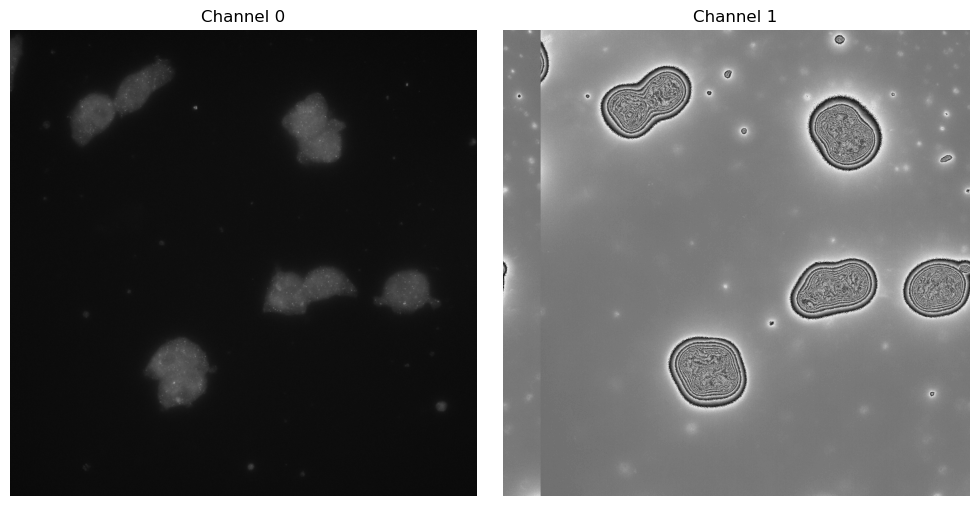

In [3]:
image_path = pathlib.Path("./multi_channel_tifs/mc1.tif")
img = tifffile.imread(image_path)  # shape: (2, H, W)
img = img.transpose(1, 2, 0)  # shape: (H, W, 2)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img[:, :, 0], cmap='gray')
axes[0].set_title("Channel 0")
axes[0].axis('off')

axes[1].imshow(img[:, :, 1], cmap='gray')
axes[1].set_title("Channel 1")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [4]:
with tifffile.TiffFile(image_path) as tif:
    print(tif.pages[0].tags)
    print()
    print(tif.pages[1].tags)

TiffTag 254 NewSubfileType @8388618 LONG @8388626 = PAGE
TiffTag 256 ImageWidth @8388630 SHORT @8388638 = 2048
TiffTag 257 ImageLength @8388642 SHORT @8388650 = 2048
TiffTag 258 BitsPerSample @8388654 SHORT @8388662 = 16
TiffTag 259 Compression @8388666 SHORT @8388674 = NONE
TiffTag 262 PhotometricInterpretation @8388678 SHORT @8388686 = MINISBLACK
TiffTag 266 FillOrder @8388690 SHORT @8388698 = MSB2LSB
TiffTag 270 ImageDescription @8388702 ASCII[81] @8388866 = ImageJ=1.54f images=
TiffTag 273 StripOffsets @8388714 LONG[8] @8388834 = (8, 1048584, 2097160, 3145
TiffTag 274 Orientation @8388726 SHORT @8388734 = TOPLEFT
TiffTag 277 SamplesPerPixel @8388738 SHORT @8388746 = 1
TiffTag 278 RowsPerStrip @8388750 SHORT @8388758 = 256
TiffTag 279 StripByteCounts @8388762 LONG[8] @8388802 = (1048576, 1048576, 1048
TiffTag 284 PlanarConfiguration @8388774 SHORT @8388782 = CONTIG
TiffTag 297 PageNumber @8388786 SHORT[2] @8388794 = (0, 2)

TiffTag 254 NewSubfileType @16777558 LONG @16777566 = PAGE


In [5]:
with tifffile.TiffFile(image_path) as tif:
    print(tif.pages[0].tags['ImageDescription'].value)
    print()
    print(tif.pages[1].tags['ImageDescription'].value)

ImageJ=1.54f
images=2
channels=2
mode=composite
loop=false
min=250.0
max=1000.0

ImageJ=1.54f
images=2
channels=2
mode=composite
loop=false
min=250.0
max=1000.0


In [6]:
with tifffile.TiffFile(pathlib.Path("./assets/demotifs/MAX_KOa_w1-359 DAPI_s021.tif")) as tif:
    print(tif.pages[0].tags)

TiffTag 256 ImageWidth @8452718 SHORT @8452726 = 2048
TiffTag 257 ImageLength @8452730 SHORT @8452738 = 2048
TiffTag 258 BitsPerSample @8452742 SHORT @8452750 = 16
TiffTag 259 Compression @8452754 SHORT @8452762 = PACKBITS
TiffTag 262 PhotometricInterpretation @8452766 SHORT @8452774 = MINISBLACK
TiffTag 273 StripOffsets @8452778 LONG[64] @8453162 = (8, 132103, 264192, 39628
TiffTag 274 Orientation @8452790 SHORT @8452798 = TOPLEFT
TiffTag 277 SamplesPerPixel @8452802 SHORT @8452810 = 1
TiffTag 278 RowsPerStrip @8452814 SHORT @8452822 = 32
TiffTag 279 StripByteCounts @8452826 LONG[64] @8452906 = (132095, 132089, 13209
TiffTag 282 XResolution @8452838 RATIONAL @8452890 = (72, 1)
TiffTag 283 YResolution @8452850 RATIONAL @8452898 = (72, 1)
TiffTag 284 PlanarConfiguration @8452862 SHORT @8452870 = CONTIG
TiffTag 296 ResolutionUnit @8452874 SHORT @8452882 = INCH


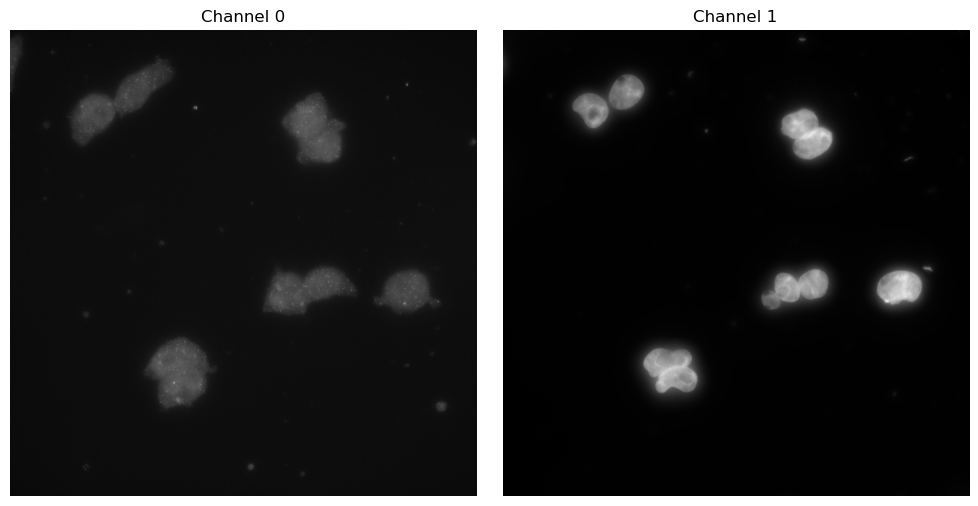

In [7]:
with tifffile.TiffFile(image_path) as tif:
    img0 = tif.pages[0].asarray()
    img1 = tif.pages[1].asarray()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0, cmap='gray')
    axes[0].set_title("Channel 0")
    axes[0].axis('off')

    axes[1].imshow(img1, cmap='gray')
    axes[1].set_title("Channel 1")
    axes[1].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# with tifffile.TiffFile(image_path) as tif:
#     viewer = napari.Viewer()

#     for i in range(len(tif.pages)):
#         viewer.add_image(
#             tif.pages[i].asarray(),
#             name=f"Channel {i}",
#             colormap='green' if i == 0 else 'magenta',
#             blending='additive',
#             opacity=0.7 if i == 1 else 1.0
#         )

#     napari.run()

[2025-05-07 14:58:52,668][INFO] PRED: generated 9 masks
[2025-05-07 14:58:52,879][INFO] PRED: generated 11 masks
[2025-05-07 14:58:53,094][INFO] PRED: generated 11 masks


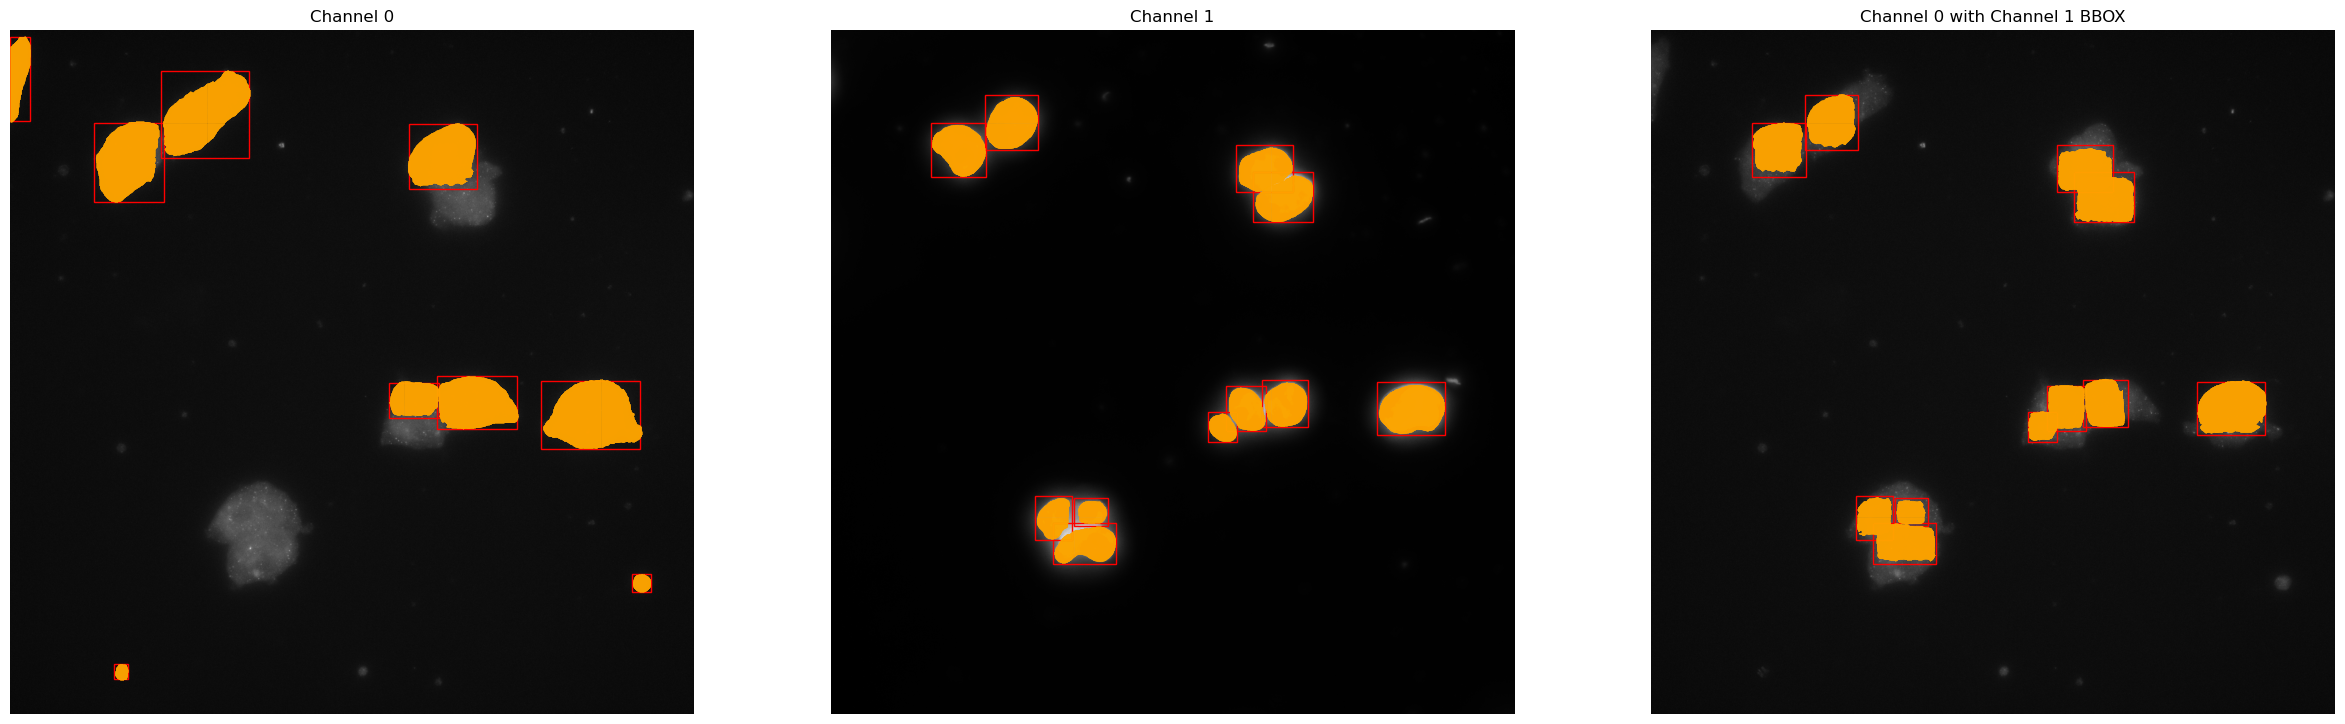

In [9]:
with tifffile.TiffFile(image_path) as tif:
    img0 = tif.pages[0].asarray()
    img1 = tif.pages[1].asarray()
    
    bbox0 = f.AppIntDINOwrapper(img0)
    bbox1 = f.AppIntDINOwrapper(img1)
    result0 = f.finetune.AppIntPREDICTwrapper(img0,bbox0)
    result1 = f.finetune.AppIntPREDICTwrapper(img1,bbox1)
    result0_by_b1 = f.finetune.AppIntPREDICTwrapper(img0,bbox1)
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].imshow(img0, cmap='gray')
    axes[0].set_title("Channel 0")
    axes[0].axis('off')
    for bbox in bbox0:
        axes[0].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
    for mask in result0:
        y, x = np.where(mask > 0)
        axes[0].scatter(x, y, s=0.5, c='orange', marker='.', linewidths=0)
    
    axes[1].imshow(img1, cmap='gray')
    axes[1].set_title("Channel 1")
    axes[1].axis('off')
    for bbox in bbox1:
        axes[1].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
    for mask in result1:
        y, x = np.where(mask > 0)
        axes[1].scatter(x, y, s=0.5, c='orange', marker='.', linewidths=0)
    
    axes[2].imshow(img0, cmap='gray')
    axes[2].set_title("Channel 0 with Channel 1 BBOX")
    axes[2].axis('off')
    for bbox in bbox1:
        axes[2].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
    for mask in result0_by_b1:
        y, x = np.where(mask > 0)
        axes[2].scatter(x, y, s=0.5, c='orange', marker='.', linewidths=0)
    
    plt.show()

[2025-05-07 15:01:24,766][INFO] PRED: generated 6 masks


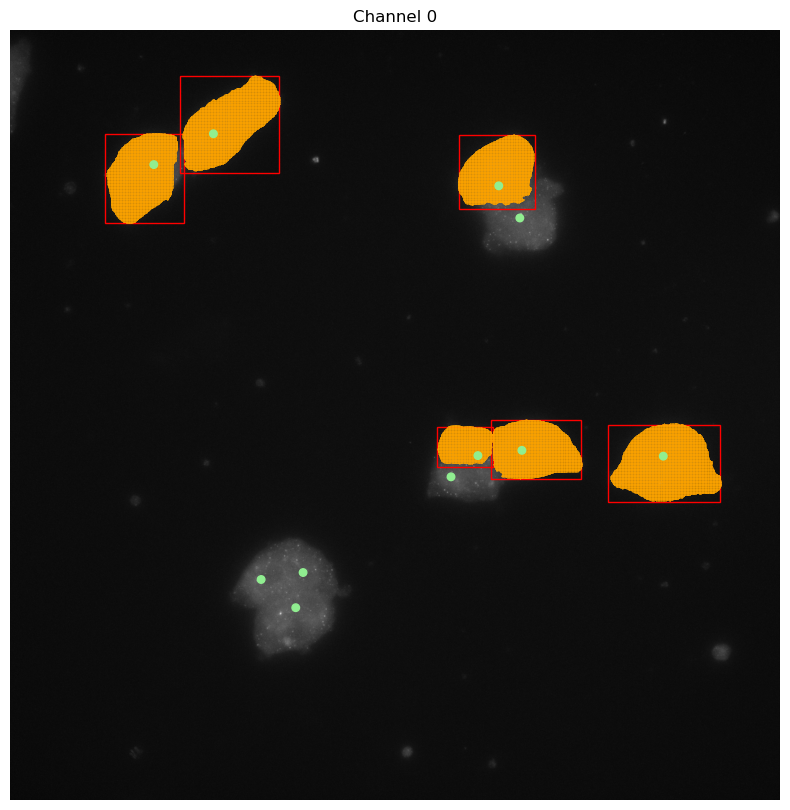

In [15]:
with tifffile.TiffFile(image_path) as tif:
    img0 = tif.pages[0].asarray()
    img1 = tif.pages[1].asarray()
    bbox1 = f.AppIntDINOwrapper(img1)
    centers = []
    for bbox in bbox1:
        x_center = (bbox[0] + bbox[2]) / 2
        y_center = (bbox[1] + bbox[3]) / 2
        centers.append((x_center, y_center))
    centers = np.array(centers)
    bbox0 = f.AppIntDINOwrapperB(img0, centers)
    result0 = f.finetune.AppIntPREDICTwrapper(img0,bbox0)

    fig, axes = plt.subplots(1, 1, figsize=(10, 10))

    axes.imshow(img0, cmap='gray')
    axes.set_title("Channel 0")
    axes.axis('off')
    for bbox in bbox0:
        axes.add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
    for mask in result0:
        y, x = np.where(mask > 0)
        axes.scatter(x, y, s=0.5, c='orange', marker='.', linewidths=0)
    for center in centers:
        axes.add_patch(Circle(center, radius=10, edgecolor='lightgreen', facecolor='lightgreen'))
    
    plt.show()